# Assignment 4 - Cell segmentation data

Please change the directory in the train-method, if necessary.

### Read in the binaries. (Methods from main.py)

In [1]:
import h5py
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf


class Data:
    def __init__(self):
        with h5py.File("cell_data.h5", "r") as data:
            self.train_images = [data["/train_image_{}".format(i)][:] for i in range(28)]
            self.train_labels = [data["/train_label_{}".format(i)][:] for i in range(28)]
            self.test_images = [data["/test_image_{}".format(i)][:] for i in range(3)]
            self.test_labels = [data["/test_label_{}".format(i)][:] for i in range(3)]

        self.input_resolution = 300
        self.label_resolution = 116

        self.offset = (300 - 116) // 2
        

    def get_train_image_list_and_label_list(self):
        n = random.randint(0, len(self.train_images) - 1)
        x = random.randint(0, (self.train_images[n].shape)[1] - self.input_resolution - 1)
        y = random.randint(0, (self.train_images[n].shape)[0] - self.input_resolution - 1)
        image = self.train_images[n][y:y + self.input_resolution, x:x + self.input_resolution, :]

        x += self.offset
        y += self.offset
        label = self.train_labels[n][y:y + self.label_resolution, x:x + self.label_resolution]

        return [image], [label]

    def get_test_image_list_and_label_list(self):
        coord_list = [[0,0],   [0, 116],   [0, 232], 
                      [116,0], [116, 116], [116, 232],
                      [219,0], [219, 116], [219, 232]]

        image_list = []
        label_list = []
    
        for image_id in range(3):
            for y, x in coord_list:
                image = self.test_images[image_id][y:y + self.input_resolution, x:x + self.input_resolution, :]
                image_list.append(image)
                x += self.offset
                y += self.offset
                label = self.test_labels[image_id][y:y + self.label_resolution, x:x + self.label_resolution]
                label_list.append(label)
    

        return image_list, label_list

### The initializing functions for the weights, biases, and pooling-, convolutionallayer. 

In [2]:
def weight_variable(shape):
    initial = tf.glorot_uniform_initializer()
    return tf.Variable(initial(shape))

def bias_variable(shape):
    initial = tf.zeros.initializer()
    return tf.Variable(initial(shape))

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def conv2d(x, W):
    return tf.nn.conv2d(x, filter=W, strides=[1, 1, 1, 1], padding='VALID')

def conv2d_transposed(x, filters): 
    return tf.layers.conv2d_transpose(inputs=x, filters=filters, kernel_size=[2, 2], strides=[2, 2], padding='VALID')

### Define some Helper functions

In [3]:
def visualizeImage(path, image):
    #size = len(image)
    #label = image
    label_pixels = np.array(image).reshape((len(image), len(image)))
    # plt.title('Original image')
    plt.imshow(label_pixels, cmap='gray')
    plt.imsave(path, label_pixels, cmap='gray')
    plt.show()
    
def getRandomTrainImageAndLabel(data):
    test_image_and_label = data.get_train_image_list_and_label_list()
    randomInt = np.random.randint(0, len(test_image_and_label[0]))
    train_image = test_image_and_label[0][randomInt].reshape((1, 300, 300))
    train_label = test_image_and_label[1][randomInt]
    return train_image, train_label

def getRandomTestImageAndLabel(data):
    test_image_and_label = data.get_test_image_list_and_label_list()
    randomInt = np.random.randint(0, len(test_image_and_label[0]))
    test_image = test_image_and_label[0][randomInt].reshape((1, 300, 300))
    test_label = test_image_and_label[1][randomInt]
    return test_image, test_label 
    
def calcInterimResult(train_image, train_label, test_image, test_label, loss, x, labels):
    """ Calculates for a random train and test image the loss"""  
    train_loss = loss.eval(feed_dict={x: train_image, labels: train_label})
    test_loss = loss.eval(feed_dict={x: test_image, labels: test_label})
    return train_loss, test_loss


# Function for rounding up or down the images. 
makeImageToBackOrForeground = np.vectorize(lambda y: 1.0 if y >= 0.5 else 0.0)

def calcAccuracy(data, accuracy, x, labels):
    test_image_and_label = data.get_test_image_list_and_label_list()
    accuracy_sum = 0
    for image in range(len(test_image_and_label[0])):
        test_image = test_image_and_label[0][image].reshape((1, 300, 300))
        test_label = test_image_and_label[1][image]
        accuracy_sum += accuracy.eval(feed_dict={x: test_image, labels: test_label})
    return accuracy_sum / len(test_image_and_label[0])


### Setting Up the architecture for the UNet

In [4]:
def nn(input_images):
    """      
        Encoder: (From top to bottom)
            Convolutional Layer 1: 300x300 
            Convolutional Layer 2: 298x298
                Max.Pooling Layer   1: 148x148
                Convolutional Layer 3: 146x146
                Convolutional Layer 4: 144x144
                    Max.Pooling Layer 2:  72x72
                    ConvolutionalLayer 5: 70x70
                    ConvolutionalLayer 6: 68x68
                        Max.Pooling Layer 3:  34x34
                        ConvolutionalLayer 7: 32x32
                        ConvolutionalLayer 8: 30x30
                            Max.Pooling Layer 3:  15x15
                            ConvolutionalLayer 7: 13x13
                            ConvolutionalLayer 8: 11x11
                          
        Decoder: (From bottom to top)
                        Transposed Convolutional Layer 1:     22x22
                        Concat T.Conv.Layer 1 + Conv.Layer 8: 22x22
                        ConvolutionalLayer 9:                 20x20
                        ConvolutionalLayer 10:                18x18
                    Transposed Convolutional Layer 2:     36x36
                    Concat T.Conv.Layer 2 + Conv.Layer 6: 36x36
                    ConvolutionalLayer 11:                34x34
                    ConvolutionalLayer 12:                32x32
                Transposed Convolutional Layer 3:     64x64
                Concat T.Conv.Layer 3 + Conv.Layer 4: 64x64
                ConvolutionalLayer 13:                62x62
                ConvolutionalLayer 14:                60x60
            Transposed Convolutional Layer 4:     120x120
            Concat T.Conv.Layer 4 + Conv.Layer 2: 120x120
            ConvolutionalLayer 15:                118x118
            ConvolutionalLayer 16:                116x116
        Convolutional Layer 17: --OUTPUT--    116x116
                    
    """
    
    # ---------------------------------------------------------------------------------------------------------------- #
    # ------------------------------------------------ ENCODER ------------------------------------------------------- # 
    # ---------------------------------------------------------------------------------------------------------------- #
    
    with tf.name_scope('reshaping'):
        x_reshaped = tf.reshape(input_images, [-1, 300, 300, 1])

    # Shape after conv. layer:  298x298, 32 filters
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([3, 3, 1, 32])
        h_conv1 = tf.nn.relu(conv2d(x_reshaped, W_conv1))
        
    # Shape after conv. layer:  296x296, 32 filters
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([3, 3, 32, 32])
        h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2))

        
    # -------------------------------------------------
    # max pool layer, result shape: 148x148, 32 filters
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv2)
    
        # Shape after conv. layer:  146x146, 64 filters
    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([3, 3, 32, 64])
        h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv3))
        
    # Shape after conv. layer:  144x144, 64 filters
    with tf.name_scope('conv4'):
        W_conv4 = weight_variable([3, 3, 64, 64])
        h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4))

        
    # -------------------------------------------------
    # max pool layer, result shape: 72x72, 64 filters
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv4)
    
    
    # Shape after conv. layer:  70x70, 128 filters
    with tf.name_scope('conv5'):
        W_conv5 = weight_variable([3, 3, 64, 128])
        h_conv5 = tf.nn.relu(conv2d(h_pool2, W_conv5))
        
        
    # Shape after conv. layer:  68x68, 128 filters
    with tf.name_scope('conv6'):
        W_conv6 = weight_variable([3, 3, 128, 128])
        h_conv6 = tf.nn.relu(conv2d(h_conv5, W_conv6))


    # -------------------------------------------------
    # max pool layer, result shape: 34x34, 128 filters
    with tf.name_scope('pool3'):
        h_pool3 = max_pool_2x2(h_conv6)
    
    # Shape after conv. layer:  32x32, 256 filters
    with tf.name_scope('conv7'):
        W_conv7 = weight_variable([3, 3, 128, 256])
        h_conv7 = tf.nn.relu(conv2d(h_pool3, W_conv7))
        
    # Shape after conv. layer:  30x30, 256 filters
    with tf.name_scope('conv8'):
        W_conv8 = weight_variable([3, 3, 256, 256])
        h_conv8 = tf.nn.relu(conv2d(h_conv7, W_conv8))


    # -------------------------------------------------
    # max pool layer, result shape: 15x15, 256 filters
    with tf.name_scope('pool4'):
        h_pool4 = max_pool_2x2(h_conv8)
    
    # Shape after conv. layer:  13x13, 512 filters
    with tf.name_scope('conv9'):
        W_conv9 = weight_variable([3, 3, 256, 512])
        h_conv9 = tf.nn.relu(conv2d(h_pool4, W_conv9))
        
    # Shape after conv. layer:  11x11, 512 filters
    with tf.name_scope('conv10'):
        W_conv10 = weight_variable([3, 3, 512, 512])
        h_conv10 = tf.nn.relu(conv2d(h_conv9, W_conv10))
    
    # ---------------------------------------------------------------------------------------------------------------- #
    # ------------------------------------------------ DECODER ------------------------------------------------------- # 
    # ---------------------------------------------------------------------------------------------------------------- #

    # Shape after transposed convolutional layer: 22x22, 256 filters
    with tf.name_scope('trans_conv1'):
        h_trans_conv1 = conv2d_transposed(h_conv10, 256)
    
    # Shape after concat with cropped layer: 22x22, 512 filters
    with tf.name_scope('reusing_features_22x22'):
        # crop image to new dimensions
        cropped_old1 = tf.image.resize_image_with_crop_or_pad(h_conv8, 22, 22)
        # concatenate the features on axis 3
        h_reused1 = tf.concat([h_trans_conv1, cropped_old1], 3)

    # Shape after conv. layer:  20x20, 256 filters
    with tf.name_scope('conv11'):
        W_conv11 = weight_variable([3, 3, 512, 256])
        h_conv11 = tf.nn.relu(conv2d(h_reused1, W_conv11))
        
    # Shape after conv. layer:  18x18, 256 filters
    with tf.name_scope('conv12'):
        W_conv12 = weight_variable([3, 3, 256, 256])
        h_conv12 = tf.nn.relu(conv2d(h_conv11, W_conv12))
        
        
    # ---------------------------------------------------------------    
    # Shape after transposed convolutional layer: 36x36, 128  filters     
    with tf.name_scope('trans_conv2'):
        h_trans_conv2 = conv2d_transposed(h_conv12, 128)
    
    # Shape after concat with cropped layer: 36x36, 256 filters
    with tf.name_scope('reusing_features_36x36'):
        cropped_old2 = tf.image.resize_image_with_crop_or_pad(h_conv6, 36, 36)
        h_reused2 = tf.concat([h_trans_conv2, cropped_old2], 3)

    # Shape after conv. layer:  34x34, 128 filters
    with tf.name_scope('conv13'):
        W_conv13 = weight_variable([3, 3, 256, 128])
        h_conv13 = tf.nn.relu(conv2d(h_reused2, W_conv13))
    
    # Shape after conv. layer:  32x32, 128 filters
    with tf.name_scope('conv14'):
        W_conv14 = weight_variable([3, 3, 128, 128])
        h_conv14 = tf.nn.relu(conv2d(h_conv13, W_conv14))
    
    
    # ---------------------------------------------------------------    
    # Shape after transposed convolutional layer: 64x64, 64  filters    
    with tf.name_scope('trans_conv2'):
        h_trans_conv3 = conv2d_transposed(h_conv14, 64)
    
    # Shape after concat with cropped layer: 36x36, 256 filters 64x64, 128 filters
    with tf.name_scope('reusing_features_64x64'):
        cropped_old3 = tf.image.resize_image_with_crop_or_pad(h_conv4, 64, 64)
        h_reused3 = tf.concat([h_trans_conv3, cropped_old3], 3)

    # Shape after conv. layer:  62x62, 64 filters
    with tf.name_scope('conv15'):
        W_conv15 = weight_variable([3, 3, 128, 64])
        h_conv15 = tf.nn.relu(conv2d(h_reused3, W_conv15))
        
    # Shape after conv. layer:  60x60, 64 filters
    with tf.name_scope('conv14'):
        W_conv16 = weight_variable([3, 3, 64, 64])
        h_conv16 = tf.nn.relu(conv2d(h_conv15, W_conv16))
        
        
    # ---------------------------------------------------------------    
    # Shape after transposed convolutional layer: 120x120, 32 filters
    with tf.name_scope('trans_conv4'):
        h_trans_conv4 = conv2d_transposed(h_conv16, 32)
    
    # Shape after concat with cropped layer: 120x120, 64 filters
    with tf.name_scope('reusing_features_120x120'):
        cropped_old4 = tf.image.resize_image_with_crop_or_pad(h_conv2, 120, 120)
        h_reused4 = tf.concat([h_trans_conv4, cropped_old4], 3)

    # Shape after conv. layer:  118x118, 32 filters
    with tf.name_scope('conv17'):
        W_conv17 = weight_variable([3, 3, 64, 32])
        h_conv17 = tf.nn.relu(conv2d(h_reused4, W_conv17))    
    
    # Shape after conv. layer:  116x116, 32 filters
    with tf.name_scope('conv18'):
        W_conv18 = weight_variable([3, 3, 32, 32])
        h_conv18 = tf.nn.relu(conv2d(h_conv17, W_conv18))
    
    # Shape after conv. layer:  116x116, 2 filters
    with tf.name_scope('outconv'):
        W_conv_out = weight_variable([1, 1, 32, 2])
        h_conv_out = conv2d(h_conv18, W_conv_out)
    
    return h_conv_out

### Starting the training

In [5]:
def train(epochs, saveOrRestore='save'):

    data = Data()
    
    path = 'C:/Users/Assignment4/'
    save_path_model = path + 'savedmodel/'
    
    # Placeholder for input
    x = tf.placeholder(tf.float32, [None, 300, 300])
    
    # Placeholder for label
    labels = tf.placeholder(tf.int8, [116, 116])
    labels_reshaped = tf.reshape(labels, [-1, 116*116, 1])
    label_with_inverse = tf.concat([labels_reshaped, 1-labels_reshaped], -1)
    
    # Placeholder for output
    y = nn(x)
    y_ = tf.reshape(y, [-1, 116*116, 2])
    
    # Calculate loss from original image
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=label_with_inverse , logits=y_)
        loss = tf.reduce_mean(cross_entropy)
    tf.summary.scalar('loss', loss)

    with tf.name_scope("AdamOptimizer"):
        train_step = tf.train.AdamOptimizer(0.0001, 0.95, 0.99).minimize(loss)
          
    with tf.name_scope('accuracy'):
        """ Sorry for doing this different to your suggestion. But it will do exactly the same """
        y_ = tf.nn.softmax(y_, -1)
        
        # Select just one layer, reshape and round up/down the values.
        layer1 = tf.split(y_, 2, -1)[0]
        reshaped = tf.reshape(layer1, (-1, 116*116))
        rounded = tf.cast(tf.round(reshaped), tf.float32)
        
        labels_reshaped = tf.cast(tf.reshape(labels_reshaped, (-1, 116*116)), tf.float32)
        
        intersection = tf.reduce_sum(tf.multiply(rounded, labels_reshaped))
        union = tf.reduce_sum(tf.clip_by_value(tf.add(rounded, labels_reshaped), 0, 1))
        
        # add epsilon to make it zero-devision-safe
        accuracy = intersection / tf.add(union, tf.constant(1e-10, dtype=tf.float32))

    tf.summary.scalar('accuracy', accuracy)
    
    merged_summary_op = tf.summary.merge_all()
    
    with tf.Session() as sess:
        saver = tf.train.Saver()
        
        if saveOrRestore is 'save':
            sess.run(tf.global_variables_initializer())
            writer = tf.summary.FileWriter(path, graph=sess.graph)
            
            for epoch in range(epochs):
                train_image, train_label = getRandomTrainImageAndLabel(data)
                
                
                if epoch % 1000 == 0:
                    test_image, test_label = getRandomTestImageAndLabel(data)
                    
                    train_loss, test_loss = calcInterimResult(train_image, train_label, 
                                                              test_image, test_label, 
                                                              loss, x, labels)
                    acc = calcAccuracy(data, accuracy, x, labels)
                    print('step %d, training loss %g, validation set loss %g' % (epoch, train_loss, test_loss))
                    print('acc: {:.6f}'.format(acc))
                    
                    
                train_step.run(feed_dict={x: train_image, labels: train_label})

                # collect data for summary
                summary_str = sess.run(merged_summary_op, feed_dict={x: train_image, labels: train_label})
                writer.add_summary(summary_str, epoch)
             
            save_path = saver.save(sess, save_path_model)
        
        elif saveOrRestore == 'restore':
            saver.restore(sess, save_path_model)
        else:
            raise ValueError('Wrong input for variable saveOrRestore!,\n'
                              'Correct values are \"safe\" or \"restore\"')
        
        # Show some test images with their original pictures.
        for i in range(4):
            picture_path = path + 'image' + str(i)
            image, label = getRandomTestImageAndLabel(data)
            
            prediction = y.eval(feed_dict={x: image, labels: label})
            acc = accuracy.eval(feed_dict={x: image, labels: label})
            lossOnTestSet = loss.eval(feed_dict={x: image, labels: label})
            
            print('loss: {} accuracy: {}'.format(lossOnTestSet, acc))
            
            layer1, layer2 = np.split(prediction, 2, -1)
            print('original picture:')
            visualizeImage(picture_path + 'origin.png', image.reshape([300,300]))
            print('picture:')
            visualizeImage(picture_path + 'pred.png', layer1.reshape([116, 116]))
            print('inverted picture:')
            visualizeImage(picture_path + 'predInv.png', layer2.reshape([116, 116]))
            print('picture rounded:')
            roundedPrediction = makeImageToBackOrForeground(prediction)
            image_rounded = roundedPrediction.reshape(116,116,2)[:,:,0]
            visualizeImage(picture_path + 'rounded.png', image_rounded.reshape((116,116)))

        

step 0, training loss 0.697994, validation set loss 0.697862
acc: 0.090171
step 1000, training loss 0.0863666, validation set loss 0.0173952
acc: 0.831801
step 2000, training loss 0.0307584, validation set loss 0.0193294
acc: 0.889042
step 3000, training loss 0.0627967, validation set loss 0.0332369
acc: 0.856478
step 4000, training loss 0.0319853, validation set loss 0.0180881
acc: 0.897732
step 5000, training loss 0.0311739, validation set loss 0.00173036
acc: 0.896699
step 6000, training loss 0.0146809, validation set loss 0.0175318
acc: 0.900280
step 7000, training loss 0.0522661, validation set loss 0.0215152
acc: 0.882525
step 8000, training loss 0.00769318, validation set loss 0.017982
acc: 0.887757
step 9000, training loss 0.00653123, validation set loss 0.0402762
acc: 0.901095
step 10000, training loss 0.0166036, validation set loss 0.0443151
acc: 0.886514
step 11000, training loss 0.10254, validation set loss 0.00816545
acc: 0.915168
step 12000, training loss 0.000481033, val

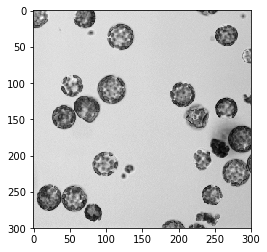

picture:


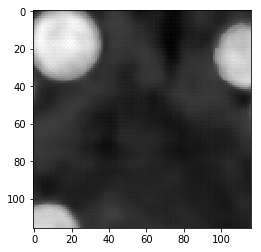

inverted picture:


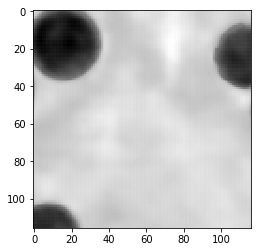

picture rounded:


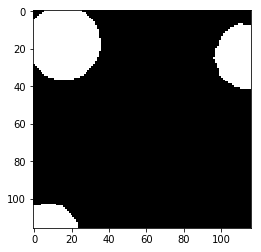

loss: 0.03027343936264515 accuracy: 0.9462517499923706
original picture:


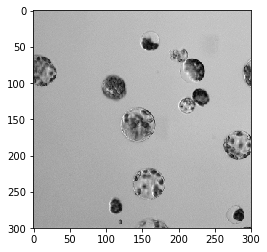

picture:


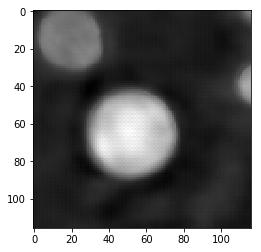

inverted picture:


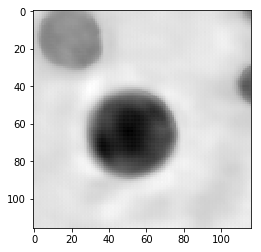

picture rounded:


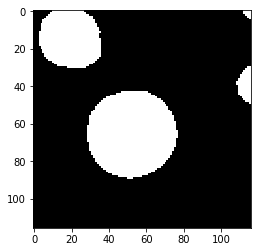

loss: 0.02999112941324711 accuracy: 0.9600870609283447
original picture:


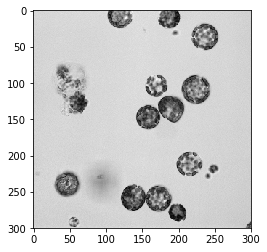

picture:


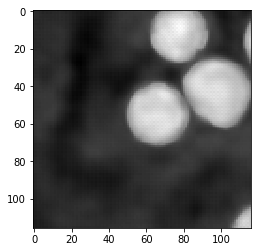

inverted picture:


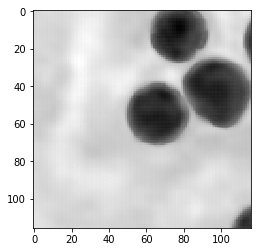

picture rounded:


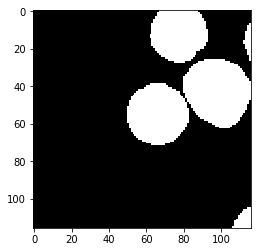

loss: 0.04531065374612808 accuracy: 0.7488788962364197
original picture:


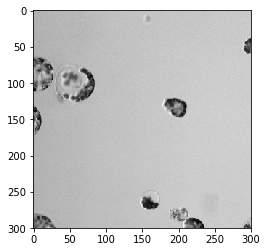

picture:


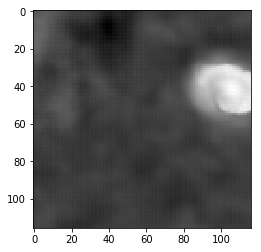

inverted picture:


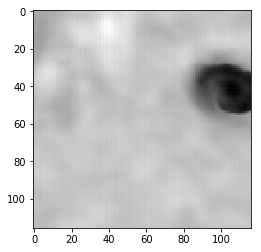

picture rounded:


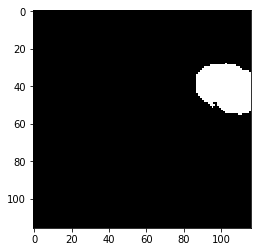

In [6]:
train(40000, saveOrRestore='save')